# Project 7: Implement a scoring model.

*Pierre-Eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.
Data used were uploaded from kaggle: https://www.kaggle.com/c/home-credit-default-risk/data

In [1]:
# File system management
import os

# Get execution time to compare models
import time

# Import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'axes.titleweight': 'bold',
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data" data-toc-modified-id="Get-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Explore-Data" data-toc-modified-id="Explore-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore Data</a></span><ul class="toc-item"><li><span><a href="#Target-distribution" data-toc-modified-id="Target-distribution-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Target distribution</a></span></li><li><span><a href="#Column-Types" data-toc-modified-id="Column-Types-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Column Types</a></span></li><li><span><a href="#Missing-Values" data-toc-modified-id="Missing-Values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Missing Values</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Outliers</a></span></li></ul></li><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare the data</a></span><ul class="toc-item"><li><span><a href="#Drop-feature-with-two-much-missing-values" data-toc-modified-id="Drop-feature-with-two-much-missing-values-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Drop feature with two much missing values</a></span></li><li><span><a href="#Fix-or-remove-outliers" data-toc-modified-id="Fix-or-remove-outliers-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fix or remove outliers</a></span></li><li><span><a href="#Encoding-Categorical-Variables" data-toc-modified-id="Encoding-Categorical-Variables-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Encoding Categorical Variables</a></span></li><li><span><a href="#Fill-in-missing-Data" data-toc-modified-id="Fill-in-missing-Data-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Fill in missing Data</a></span></li><li><span><a href="#Looking-for-Correlations" data-toc-modified-id="Looking-for-Correlations-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Looking for Correlations</a></span></li><li><span><a href="#Scaling-features" data-toc-modified-id="Scaling-features-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Scaling features</a></span></li><li><span><a href="#Transformation-Pipelines" data-toc-modified-id="Transformation-Pipelines-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Transformation Pipelines</a></span></li></ul></li><li><span><a href="#Shortlist-Promising-Models" data-toc-modified-id="Shortlist-Promising-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shortlist Promising Models</a></span><ul class="toc-item"><li><span><a href="#Select-a-Performance-Measure" data-toc-modified-id="Select-a-Performance-Measure-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Select a Performance Measure</a></span></li><li><span><a href="#Train-quick-and-dirty-models-and-compare-their-performance" data-toc-modified-id="Train-quick-and-dirty-models-and-compare-their-performance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Train quick and dirty models and compare their performance</a></span></li><li><span><a href="#Analyse-the-most-significant-variables" data-toc-modified-id="Analyse-the-most-significant-variables-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Analyse the most significant variables</a></span></li></ul></li><li><span><a href="#Fine-Tune-the-System" data-toc-modified-id="Fine-Tune-the-System-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fine-Tune the System</a></span><ul class="toc-item"><li><span><a href="#Use-as-much-data-as-possible-by-merging-all-tables" data-toc-modified-id="Use-as-much-data-as-possible-by-merging-all-tables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Use as much data as possible by merging all tables</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Aggregate-features-into-promising-new-features" data-toc-modified-id="Aggregate-features-into-promising-new-features-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Aggregate features into promising new features</a></span></li><li><span><a href="#Data-augmentation-with-SMOTE" data-toc-modified-id="Data-augmentation-with-SMOTE-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Data augmentation with SMOTE</a></span></li><li><span><a href="#Fine-Tune-the-hyperparameters-using-cross-validation" data-toc-modified-id="Fine-Tune-the-hyperparameters-using-cross-validation-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Fine-Tune the hyperparameters using cross-validation</a></span></li><li><span><a href="#Try-ensemble-methods-and-select-the-final-model" data-toc-modified-id="Try-ensemble-methods-and-select-the-final-model-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Try ensemble methods and select the final model</a></span></li></ul></li></ul></div>

## Get data

In [2]:
# List all files gathering data
list_files = sorted(os.listdir("data/"), key=str.lower)
for i, file in enumerate(list_files):
    print("{}) {}".format(i+1, file))

1) application_test.csv
2) application_train.csv
3) bureau.csv
4) bureau_balance.csv
5) credit_card_balance.csv
6) HomeCredit_columns_description.csv
7) installments_payments.csv
8) POS_CASH_balance.csv
9) previous_application.csv
10) sample_submission.csv


In [3]:
app_train = pd.read_csv("data/" + list_files[1])
print("Training data shape: {}".format(app_train.shape))
app_train.head()

Training data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_test = pd.read_csv("data/" + list_files[0])
print("Testing data shape: {}".format(app_test.shape))
app_test.head()

Testing data shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
n_train = len(app_train)
n_test = len(app_test)
n_data = n_train + n_test
print("Percentage of data for training: {:.2%}".format(n_train/n_data))
print("Percentage of data for testing: {:.2%}".format(n_test/n_data))

Percentage of data for training: 86.32%
Percentage of data for testing: 13.68%


In [6]:
cols_train = app_train.columns
cols_test = app_test.columns
miss_cols = [col for col in cols_train
             if col not in cols_test]
print("The missing columns in the test set are: {}")
for i, col in enumerate(miss_cols):
    print("{}) {}".format(i+1, col))

The missing columns in the test set are: {}
1) TARGET


## Explore Data

### Target distribution

In [7]:
df = app_train.copy()

In [8]:
target = df['TARGET'].astype(int)
target.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

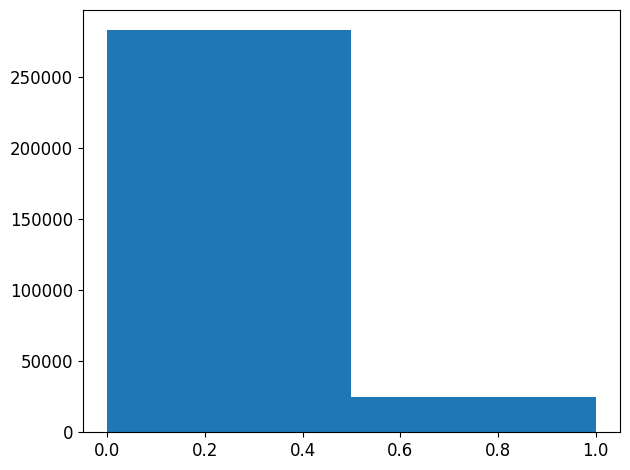

In [9]:
plt.hist(target, bins=2)
save_fig("target_distribution")
plt.show()

In [10]:
n_pos = (target == 1).sum()
n_neg = (target == 0).sum()
n_all = n_pos + n_neg
print("Percentage of data for class 0: {:.2%}".format(n_neg/n_all))
print("Percentage of data for class 1: {:.2%}".format(n_pos/n_all))

Percentage of data for class 0: 91.93%
Percentage of data for class 1: 8.07%


**The dataset is severly imbalanced.** Using a data augmentation technique like SMOTE (Synthetic Minority Oversampling Technique) may significantly improve the model performance.

### Column Types

In [11]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [12]:
# Number of unique classes in each object column
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Object columns are categorical variables.

### Missing Values

In [13]:
def missing_values_table(df):
    """Function to calculate missing values by column."""
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = (df.isnull().sum() / len(df) * 100).round(1)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table.rename(columns={0: 'Missing Values',
                                  1: '% of Total Values'},
                         inplace=True)
        
    # Sort the table by percentage of missing descending
    mask = (mis_val_table.iloc[:, 1] != 0)
    mis_val_table = mis_val_table[mask].sort_values('% of Total Values',
                                                    ascending=False)
        
    # Print some summary information
    print("Your selected dataframe has {} columns.".format(df.shape[1]))
    print("There are {} columns that have missing values.".format(len(mis_val_table)))
    # Return the dataframe with missing information
    return mis_val_table

In [14]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FONDKAPREMONT_MODE,210295,68.4


In [15]:
missing_values.tail(20)

,Missing Values,% of Total Values
YEARS_BEGINEXPLUATATION_MEDI,150007,48.8
YEARS_BEGINEXPLUATATION_MODE,150007,48.8
YEARS_BEGINEXPLUATATION_AVG,150007,48.8
TOTALAREA_MODE,148431,48.3
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
EXT_SOURCE_3,60965,19.8
AMT_REQ_CREDIT_BUREAU_MON,41519,13.5
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.5


### Outliers

In [16]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


19 children look a lot, let's see the number of clients with more than 10 children.

In [18]:
mask_child = (df['CNT_CHILDREN'] > 10)
n_child_anom = df[mask_child].CNT_CHILDREN.sum()
print("{}({:.2%}) clients seem to have an abnormally high number of children.".format(n_child_anom,
                                                                                      n_child_anom/len(df)))

115(0.04%) clients seem to have an abnormally high number of children.


Let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [19]:
anom_child = df[mask_child]
non_anom_child = df[~mask_child]
print("The non-anomalies default on {:.2%} of loans".format(non_anom_child['TARGET'].mean()))
print("The anomalies default on {:.2%} of loans".format(anom_child['TARGET'].mean()))

The non-anomalies default on 8.07% of loans
The anomalies default on 12.50% of loans


That is extremely interesting! It appears that people with a very large number of children have a much higher probability to be in default (which is quite intuitive). Thus, it would be wiser to keep these outliers.

Numbers in the `DAYS_birth` column are negative, while we could expect positive ones. That may be explain by the fact these records are relative to the current loan application.

In [20]:
(df['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable, which is clearly not the case for the several numbers in the `DAYS_EMPLOYED` column.
Some are negatives, and other too high

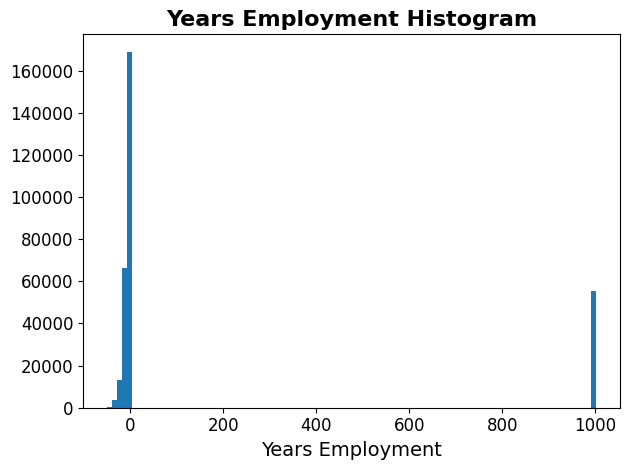

In [21]:
plt.hist(df['DAYS_EMPLOYED']/365, bins=100)
plt.title('Years Employment Histogram')
plt.xlabel('Years Employment')
save_fig("Years_Employment_distribution")
plt.show()

It does not look right, clearly. Many values are around -1000 years. Minus because like `DAYS_birth`, records are relative to the current loan application and so negative values are expected.! Moreover, these anomalies appear to have the exact same value.

As for `CNT_CHILDREN` let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [22]:
mask_empl = (df['DAYS_EMPLOYED'] > 365*50)
anom_empl = df[mask_empl]
non_anom_empl = df[~mask_empl]
print("The non-anomalies default on {:.2%} of loans".format(non_anom_empl['TARGET'].mean()))
print("The anomalies default on {:.2%} of loans".format(anom_empl['TARGET'].mean()))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans


It turns out that the anomalies have a lower rate of default, and so may content some importance. That is why we will keep those clients.  
In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. As a solution, we will replace the anomalous values with the median of the `DAYS_EMPLOYED` column (without outliers) create a new boolean column indicating whether or not the value was anomalous.

## Prepare the data

###  Drop feature with two much missing values 

As seen previously, lot of data are missing, let's only keep features with less than 30% of missing values.

In [23]:
mask = (missing_values['% of Total Values'] > 30)
feat_to_del = missing_values[mask].index
df.drop(columns=feat_to_del, inplace=True)
n_del = app_train.shape[1] - df.shape[1]
print("{} features have been discarded".format(n_del))

50 features have been discarded


### Fix or remove outliers 

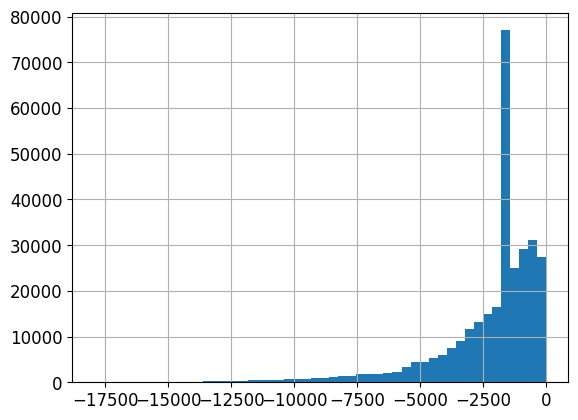

In [24]:
df.loc[anom_empl.index, 'DAYS_EMPLOYED'] = non_anom_empl['DAYS_EMPLOYED'].median()
df['DAYS_EMPLOYED'].hist(bins=50)
plt.show()

### Encoding Categorical Variables

Let's implement the following policy:

*for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.*

For label encoding, we use the Scikit-Learn `LabelEncoder` class and for one-hot encoding, the pandas `get_dummies(df)` method.

In [27]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
encoder = LabelEncoder()
n_encoder = 0

# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # Train on the training data
            encoder.fit(df[col])
            # Transform both training and testing data
            df[col] = encoder.transform(df[col])
            # Keep track of how many columns were label encoded
            n_encoder += 1
            
print("{} columns were label encoded.".format(n_encoder))

2 columns were label encoded.


In [28]:
df = pd.get_dummies(df)
print('Training Features shape: {}'.format(df.shape))

Training Features shape: (307511, 164)


### Fill in missing Data

### Looking for Correlations

### Scaling features

### Transformation Pipelines

## Shortlist Promising Models

### Select a Performance Measure

### Train quick and dirty models and compare their performance

### Analyse the most significant variables

## Fine-Tune the System

### Use as much data as possible by merging all tables

### Feature Selection

### Aggregate features into promising new features

### Data augmentation with SMOTE

### Fine-Tune the hyperparameters using cross-validation

### Try ensemble methods and select the final model